In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import PhillipsPerron
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.stats.diagnostic import het_breuschpagan, acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

ASEAN5_COUNTRIES = ['Indonesia', 'Malaysia', 'Philippines', 'Singapore', 'Thailand']
VARIABLES_TO_PLOT = ['depreciation', 'corr_inv', 'infl_diff', 'ca_gdp', 'reserves_moi', 'gdp_growth']
VARIABLES_TO_TEST = ['depreciation', 'corr_inv', 'infl_diff', 'ca_gdp', 'reserves_moi', 'gdp_growth']
MAX_LAG = 7


In [18]:
df = pd.read_csv("Data/panel_asean5_cleaned.csv")
print(f"Data loaded: {df.shape}")
df.head()


Data loaded: (150, 20)


,year,exchange_rate,Corruption Perception Index,gdp_growth,ca_gdp,infl_diff,reserves_moi,country,log_exchange_rate,depreciation,lreserves_moi,corr_inv,corr_inv_l1,infl_diff_l1,ca_gdp_l1,reserves_moi_l1,gdp_growth_l1,AFC_97_98,GFC_08_09,COVID_20_22
0,1995.0,25.6763,27.7,4.625225,-2.339200,6.831996,2.613809,Filipina,3.245568,NaN,0.960809,72.3,NaN,NaN,NaN,NaN,NaN,0,0,0
1,1996.0,26.2028,26.9,5.860348,-4.176524,7.476104,3.204902,Filipina,3.265866,0.020298,1.164681,73.1,72.3,6.831996,-2.339200,2.613809,4.625225,0,0,0
2,1997.0,29.5693,30.5,5.186412,-4.623494,5.590259,1.961715,Filipina,3.386737,0.120870,0.673819,69.5,73.1,7.476104,-4.176524,3.204902,5.860348,1,0,0
3,1998.0,40.7572,33.0,-0.514090,2.075379,9.234934,3.074316,Filipina,3.707633,0.320896,1.123082,67.0,69.5,5.590259,-4.623494,1.961715,5.186412,1,0,0
4,1999.0,39.0886,36.0,3.346451,-3.357069,5.939049,5.172271,Filipina,3.665831,-0.041802,1.643312,64.0,67.0,9.234934,2.075379,3.074316,-0.514090,0,0,0


# Visualization & Descriptive Statistics


Unique countries in data: ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


Plotting depreciation: Countries with data = ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


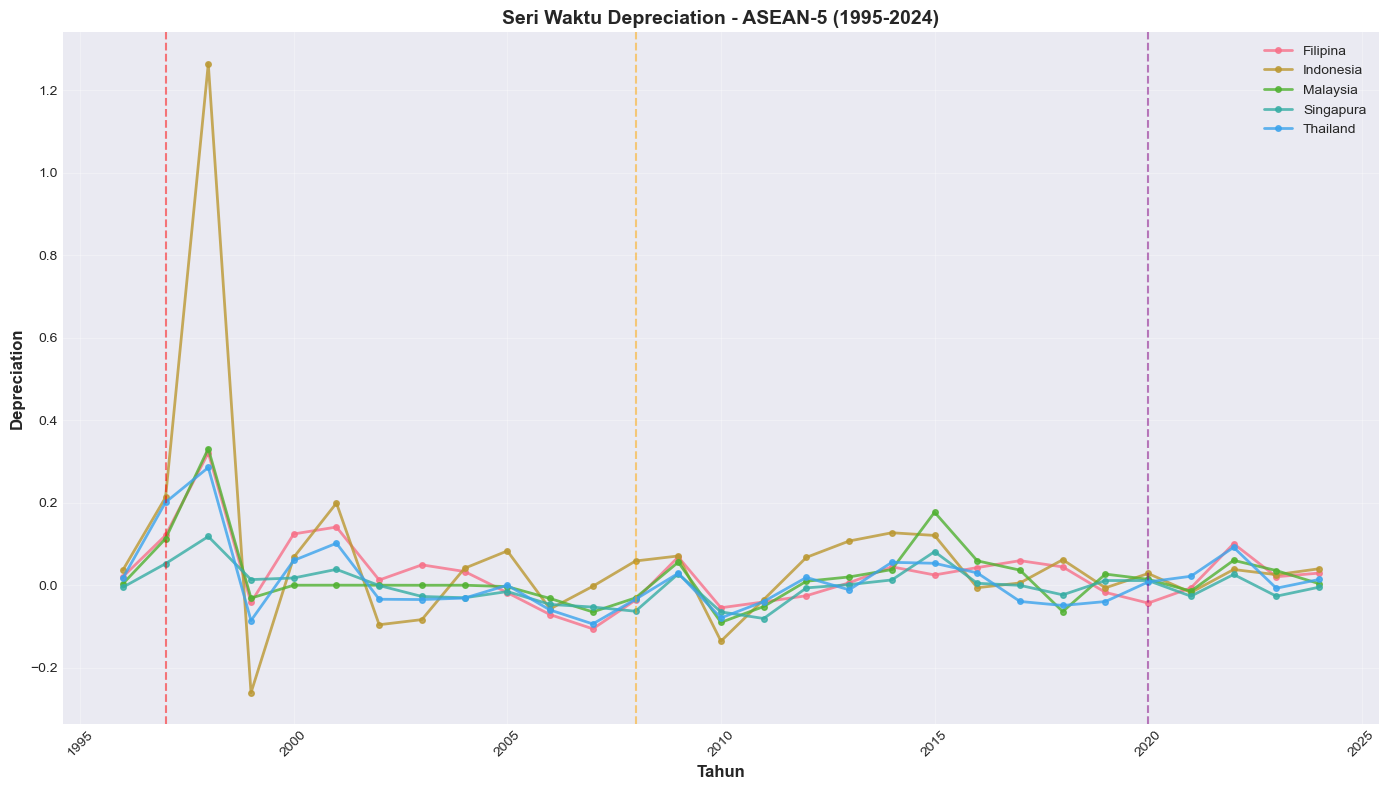

Plotting corr_inv: Countries with data = ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


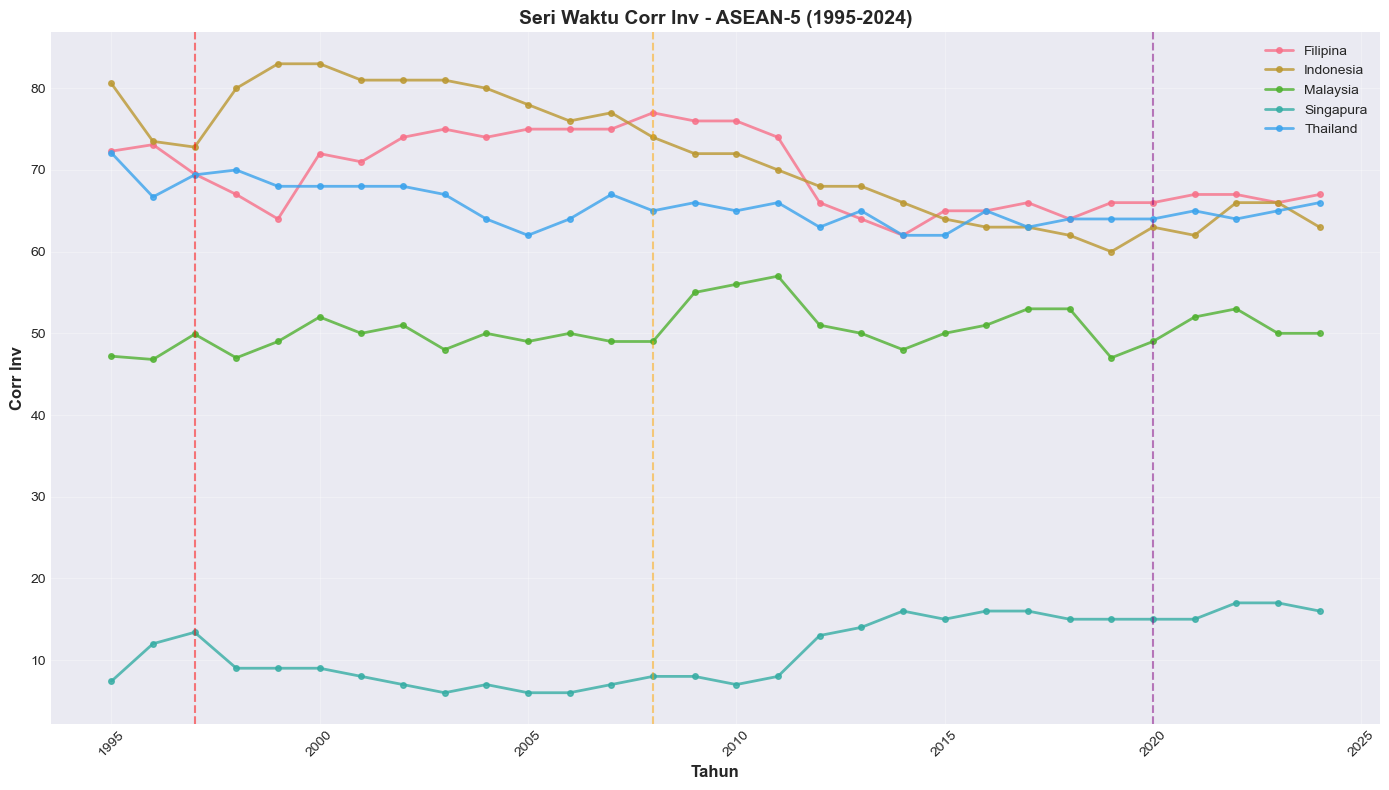

Plotting infl_diff: Countries with data = ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


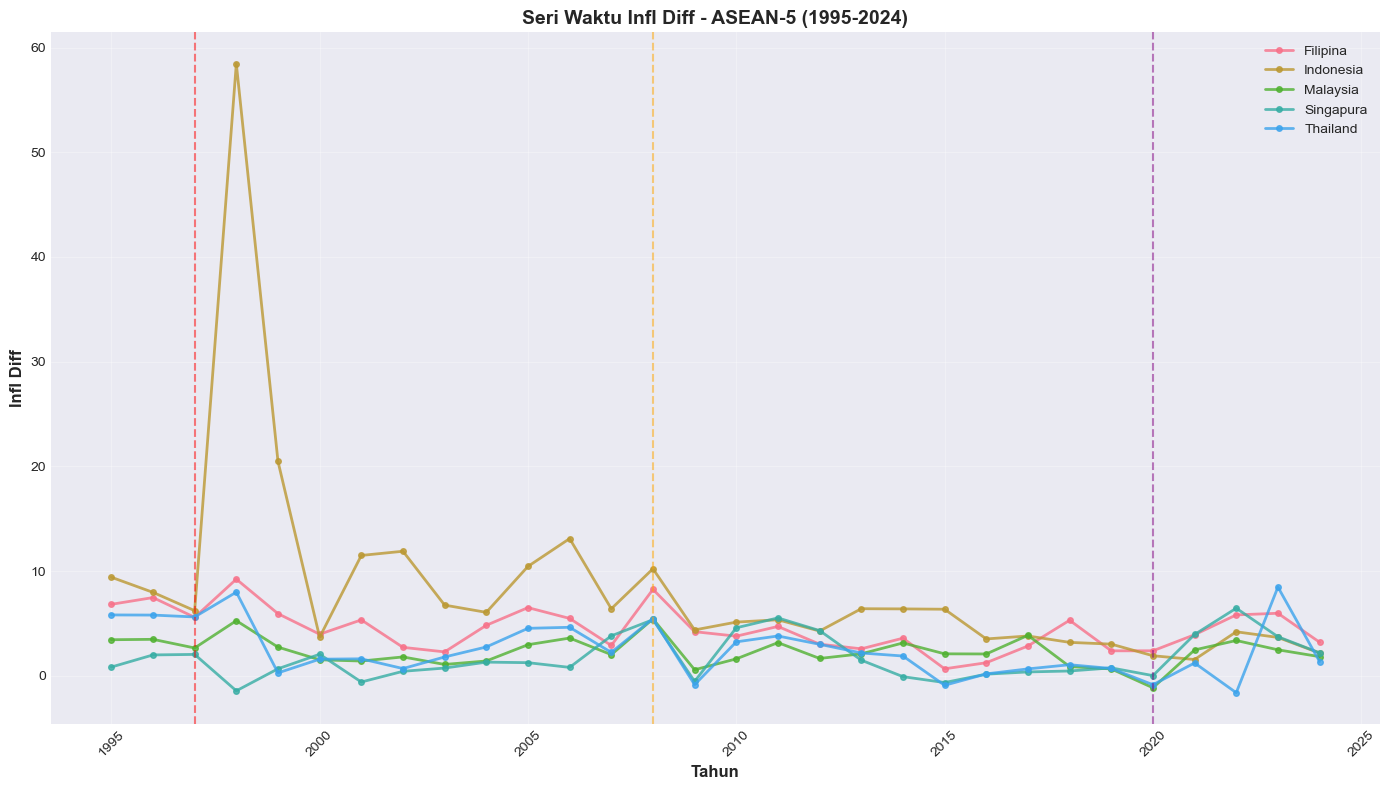

Plotting ca_gdp: Countries with data = ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


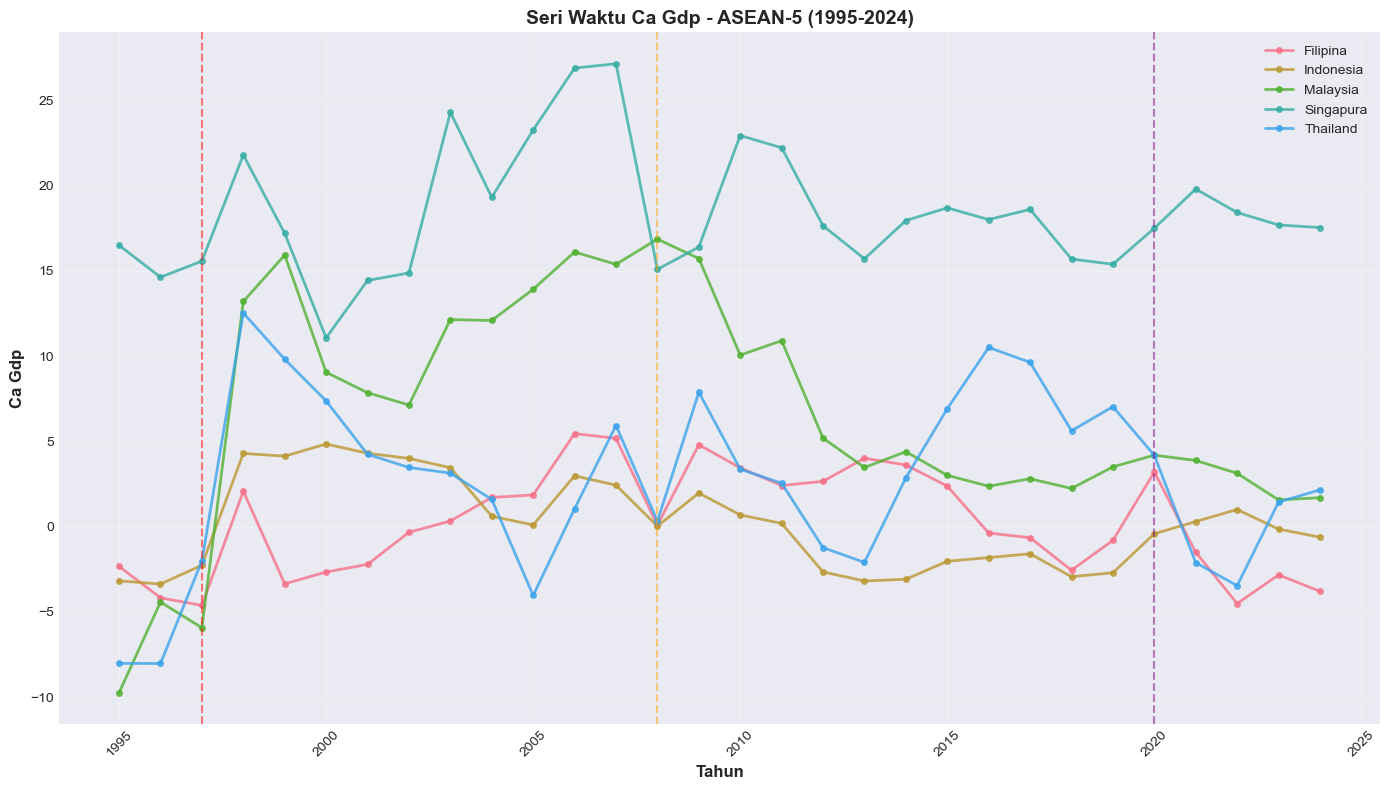

Plotting reserves_moi: Countries with data = ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


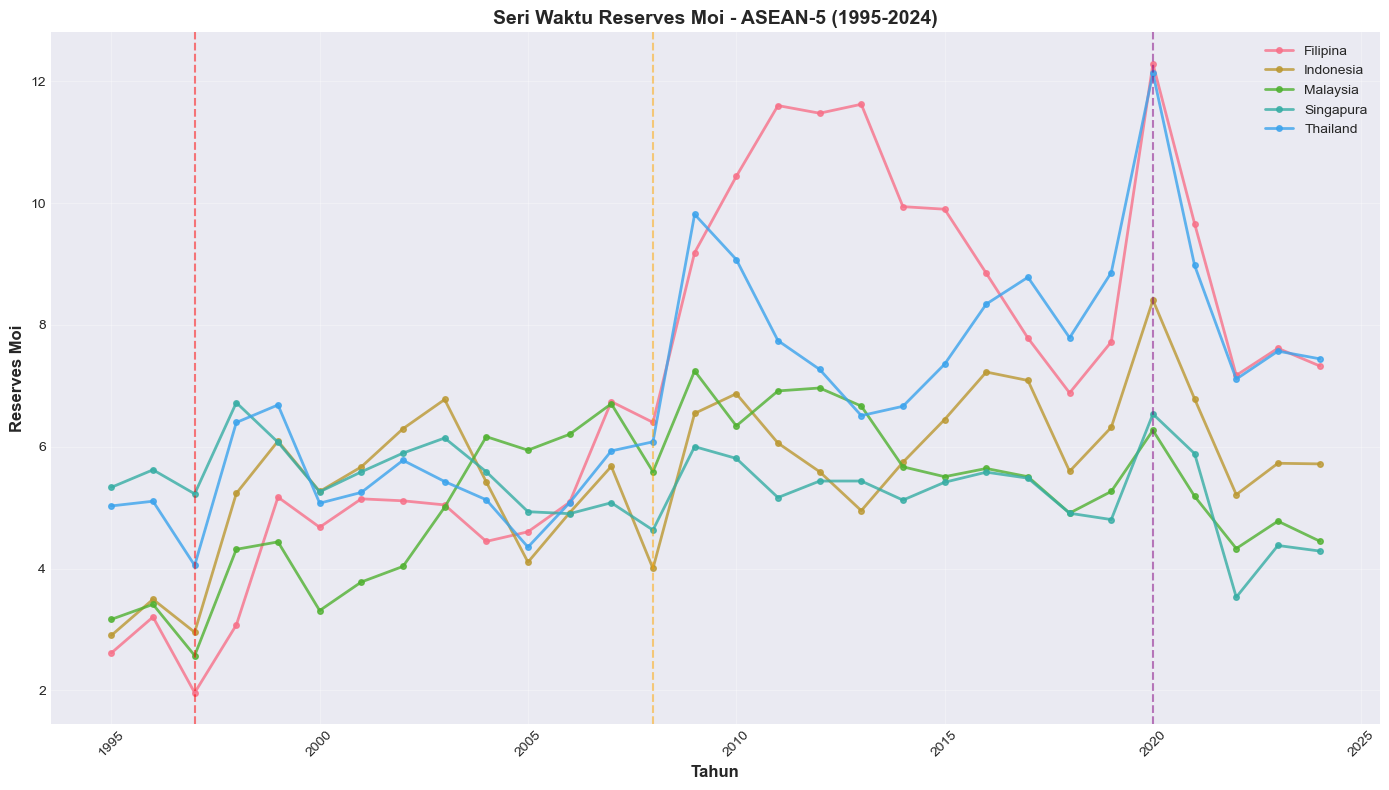

Plotting gdp_growth: Countries with data = ['Filipina' 'Indonesia' 'Malaysia' 'Singapura' 'Thailand']


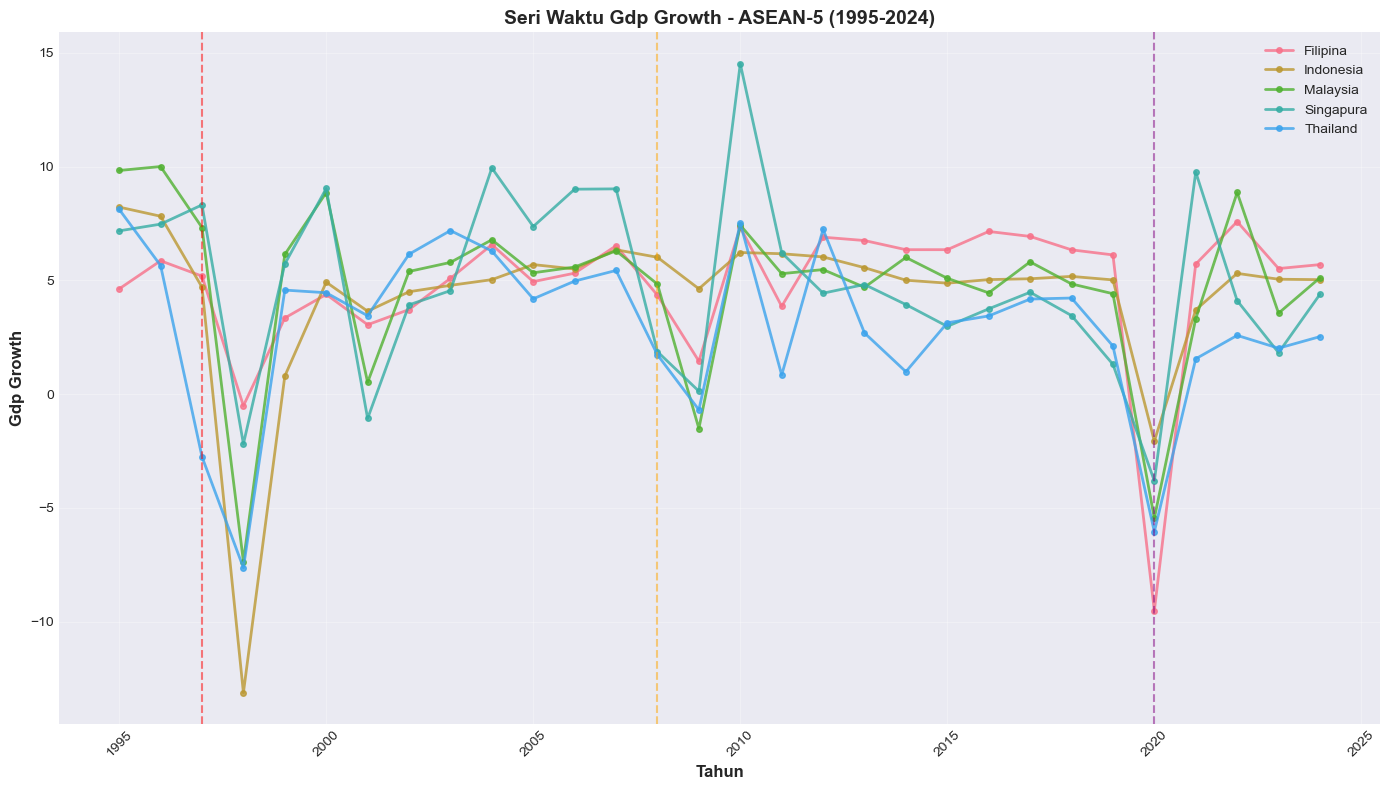

In [21]:
import os
os.makedirs('Output/Plots', exist_ok=True)

print("Unique countries in data:", df['country'].unique())
print("\n")

for var in VARIABLES_TO_PLOT:
    if var not in df.columns:
        continue
    plot_data = df[['year', 'country', var]].dropna()
    if len(plot_data) == 0:
        continue
    
    countries_in_data = plot_data['country'].unique()
    print(f"Plotting {var}: Countries with data = {countries_in_data}")
    
    fig, ax = plt.subplots(figsize=(14, 8))
    for country in countries_in_data:
        country_data = plot_data[plot_data['country'] == country]
        if len(country_data) > 0:
            ax.plot(country_data['year'], country_data[var], marker='o', markersize=4, 
                   linewidth=2, label=country, alpha=0.8)
    
    ax.axvline(x=1997, color='red', linestyle='--', alpha=0.5)
    ax.axvline(x=2008, color='orange', linestyle='--', alpha=0.5)
    ax.axvline(x=2020, color='purple', linestyle='--', alpha=0.5)
    
    ax.set_xlabel('Tahun', fontsize=12, fontweight='bold')
    ax.set_ylabel(var.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_title(f'Seri Waktu {var.replace("_", " ").title()} - ASEAN-5 (1995-2024)', 
                fontsize=14, fontweight='bold')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'Output/Plots/plot_{var}.png', dpi=300, bbox_inches='tight')
    plt.show()


In [22]:
vars_available = [v for v in VARIABLES_TO_PLOT if v in df.columns]
stats_pooled = df[vars_available].describe().T[['mean', 'std', 'min', 'max', 'count']]
stats_pooled.columns = ['Mean', 'Std Dev', 'Min', 'Max', 'N']
print("Statistik Deskriptif - Pooled:")
display(stats_pooled.round(4))
stats_pooled.to_csv('Output/descriptive_stats_pooled.csv')


Statistik Deskriptif - Pooled:


,Mean,Std Dev,Min,Max,N
depreciation,0.0252,0.1296,-0.2606,1.2641,145.0
corr_inv,53.7247,23.0309,6.0000,83.0000,150.0
infl_diff,3.8524,5.4500,-1.6107,58.4510,150.0
ca_gdp,5.6275,8.1775,-9.7441,27.1433,150.0
reserves_moi,6.0379,1.9031,1.9617,12.2854,150.0
gdp_growth,4.3518,3.7131,-13.1267,14.5198,150.0


In [23]:
stats_by_country = df.groupby('country')[vars_available].agg(['mean', 'std', 'min', 'max', 'count'])
stats_by_country.columns = ['_'.join(col).strip() for col in stats_by_country.columns.values]
print("Statistik Deskriptif - Per Negara:")
display(stats_by_country.round(4))
stats_by_country.to_csv('Output/descriptive_stats_by_country.csv')


Statistik Deskriptif - Per Negara:


,depreciation_mean,depreciation_std,depreciation_min,depreciation_max,depreciation_count,corr_inv_mean,corr_inv_std,corr_inv_min,corr_inv_max,corr_inv_count,...,reserves_moi_mean,reserves_moi_std,reserves_moi_min,reserves_moi_max,reserves_moi_count,gdp_growth_mean,gdp_growth_std,gdp_growth_min,gdp_growth_max,gdp_growth_count
country,,,,,,,,,,,,,,,,,,,,,
Filipina,0.0277,0.0820,-0.1058,0.3209,29,69.6967,4.6401,62.0,77.0,30,...,7.0911,2.9146,1.9617,12.2854,30,4.7648,3.2340,-9.5183,7.5810,30
Indonesia,0.0674,0.2490,-0.2606,1.2641,29,71.6300,7.5264,60.0,83.0,30,...,5.6362,1.2462,2.9021,8.4070,30,4.3547,3.7785,-13.1267,8.2200,30
Malaysia,0.0208,0.0800,-0.0901,0.3311,29,50.4300,2.5700,46.8,57.0,30,...,5.2096,1.2390,2.5719,7.2446,30,4.7566,3.8389,-7.3594,10.0027,30
Singapura,-0.0020,0.0425,-0.0807,0.1181,29,11.2600,4.0245,6.0,17.0,30,...,5.3593,0.6667,3.5302,6.7233,30,4.8800,3.9441,-3.8147,14.5198,30
Thailand,0.0120,0.0817,-0.0939,0.2854,29,65.6067,2.4538,62.0,72.1,30,...,6.8931,1.8229,4.0518,12.1329,30,3.0030,3.6455,-7.6340,8.1203,30


Matriks Korelasi - Pooled:


,depreciation,corr_inv,infl_diff,ca_gdp,reserves_moi,gdp_growth
depreciation,1.0000,0.1356,0.6675,-0.1329,-0.1705,-0.4846
corr_inv,0.1356,1.0000,0.3302,-0.8025,0.1926,-0.0978
infl_diff,0.6675,0.3302,1.0000,-0.2037,-0.1677,-0.2731
ca_gdp,-0.1329,-0.8025,-0.2037,1.0000,-0.0357,-0.0352
reserves_moi,-0.1705,0.1926,-0.1677,-0.0357,1.0000,-0.2025
gdp_growth,-0.4846,-0.0978,-0.2731,-0.0352,-0.2025,1.0000


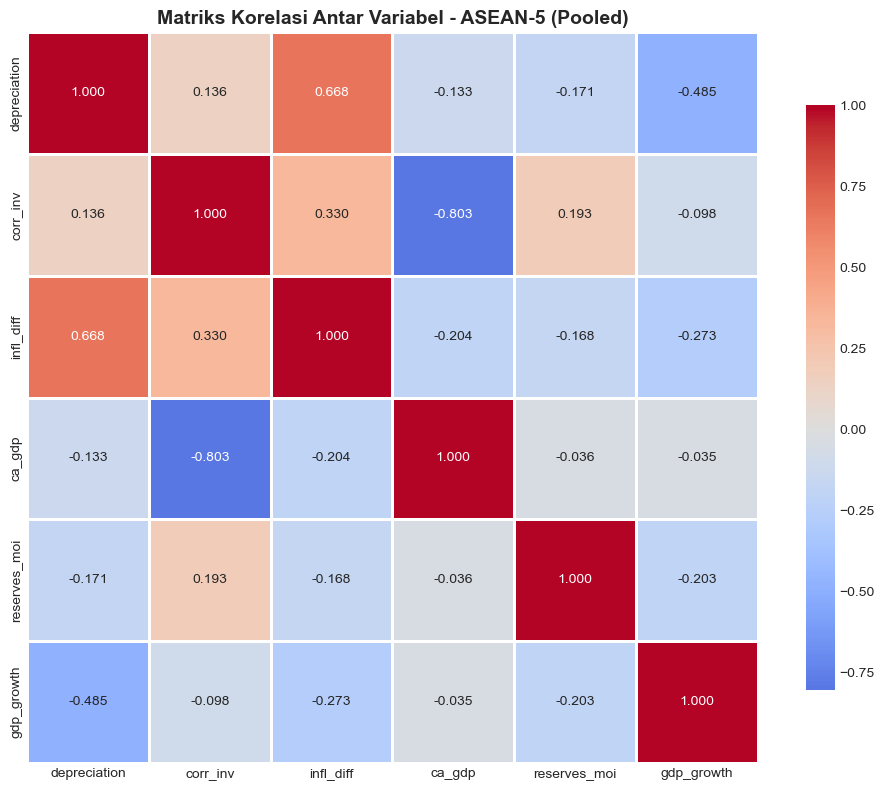

In [24]:
corr_matrix = df[vars_available].corr()
print("Matriks Korelasi - Pooled:")
display(corr_matrix.round(4))

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriks Korelasi Antar Variabel - ASEAN-5 (Pooled)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('Output/Plots/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

corr_matrix.to_csv('Output/correlation_matrix.csv')


# Uji Stasioner

In [25]:
os.makedirs('Output/UnitRootTests', exist_ok=True)

def adf_test_series(series, maxlag=7, regression='c', autolag='AIC'):
    series_clean = series.dropna()
    if len(series_clean) < 10:
        return {'adf_statistic': np.nan, 'pvalue': np.nan, 'lags_used': np.nan, 
                'nobs': len(series_clean), 'critical_values': {}}
    try:
        result = adfuller(series_clean, maxlag=maxlag, regression=regression, autolag=autolag)
        return {'adf_statistic': result[0], 'pvalue': result[1], 'lags_used': result[2],
                'nobs': result[3], 'critical_values': result[4]}
    except:
        return {'adf_statistic': np.nan, 'pvalue': np.nan, 'lags_used': np.nan,
                'nobs': len(series_clean), 'critical_values': {}}


In [26]:
all_adf_level = []
all_adf_diff = []
all_pp_level = []
all_pp_diff = []

for var in VARIABLES_TO_TEST:
    if var not in df.columns:
        continue
    
    print(f"\n{'='*70}")
    print(f"TESTING: {var}")
    print(f"{'='*70}")
    
    results_list_level = []
    results_list_diff = []
    
    for country in ASEAN5_COUNTRIES:
        country_data = df[df['country'] == country].sort_values('year')
        series = country_data[var]
        
        if len(series.dropna()) < 10:
            continue
        
        for regression, reg_name in [('c', 'Constant'), ('ct', 'Const+Trend'), ('nc', 'None')]:
            result = adf_test_series(series, maxlag=MAX_LAG, regression=regression, autolag='AIC')
            if not (np.isnan(result['adf_statistic']) and np.isnan(result['pvalue'])):
                results_list_level.append({
                    'country': country, 'variable': var, 'specification': reg_name,
                    'adf_statistic': result['adf_statistic'], 'pvalue': result['pvalue'],
                    'lags_used': result['lags_used'], 'nobs': result['nobs'],
                    'critical_1pct': result['critical_values'].get('1%', np.nan),
                    'critical_5pct': result['critical_values'].get('5%', np.nan),
                    'critical_10pct': result['critical_values'].get('10%', np.nan)
                })
        
        df_diff = country_data.copy()
        df_diff[f'{var}_diff'] = df_diff[var].diff()
        series_diff = df_diff[f'{var}_diff']
        
        if len(series_diff.dropna()) >= 10:
            result_diff = adf_test_series(series_diff, maxlag=MAX_LAG, regression='c', autolag='AIC')
            if not (np.isnan(result_diff['adf_statistic']) and np.isnan(result_diff['pvalue'])):
                results_list_diff.append({
                    'country': country, 'variable': var, 'specification': 'Constant',
                    'adf_statistic': result_diff['adf_statistic'], 'pvalue': result_diff['pvalue'],
                    'lags_used': result_diff['lags_used'], 'nobs': result_diff['nobs'],
                    'critical_1pct': result_diff['critical_values'].get('1%', np.nan),
                    'critical_5pct': result_diff['critical_values'].get('5%', np.nan),
                    'critical_10pct': result_diff['critical_values'].get('10%', np.nan)
                })
    
    if results_list_level:
        adf_level_df = pd.DataFrame(results_list_level)
        adf_level_df = adf_level_df.dropna(subset=['adf_statistic', 'pvalue'], how='all')
        all_adf_level.append(adf_level_df)
        adf_level_df.to_csv(f'Output/UnitRootTests/adf_{var}_level.csv', index=False)
        print(f"\nADF Level Results for {var}:")
        display(adf_level_df)
    
    if results_list_diff:
        adf_diff_df = pd.DataFrame(results_list_diff)
        adf_diff_df = adf_diff_df.dropna(subset=['adf_statistic', 'pvalue'], how='all')
        all_adf_diff.append(adf_diff_df)
        adf_diff_df.to_csv(f'Output/UnitRootTests/adf_{var}_diff.csv', index=False)
        print(f"\nADF First Difference Results for {var}:")
        display(adf_diff_df)



TESTING: depreciation

ADF Level Results for depreciation:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,depreciation,Constant,-3.975247,0.001546,1,27,-3.699608,-2.976430,-2.627601
1,Indonesia,depreciation,Const+Trend,-4.368177,0.002460,1,27,-4.339882,-3.587798,-3.229334
2,Malaysia,depreciation,Constant,-4.205753,0.000644,0,28,-3.688926,-2.971989,-2.625296
3,Malaysia,depreciation,Const+Trend,-4.191104,0.004617,0,28,-4.324466,-3.580882,-3.225419
4,Thailand,depreciation,Constant,-3.928884,0.001832,0,28,-3.688926,-2.971989,-2.625296
5,Thailand,depreciation,Const+Trend,-4.035620,0.007821,0,28,-4.324466,-3.580882,-3.225419



ADF First Difference Results for depreciation:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,depreciation,Constant,-5.650296,9.895985e-07,2,25,-3.723863,-2.986489,-2.632800
1,Malaysia,depreciation,Constant,-7.362342,9.428535e-11,0,27,-3.699608,-2.976430,-2.627601
2,Thailand,depreciation,Constant,-9.278580,1.269154e-15,1,26,-3.711212,-2.981247,-2.630095



TESTING: corr_inv

ADF Level Results for corr_inv:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,corr_inv,Constant,-0.938006,0.775199,0,29,-3.679060,-2.967882,-2.623158
1,Indonesia,corr_inv,Const+Trend,-1.915070,0.646825,0,29,-4.310249,-3.574488,-3.221793
2,Malaysia,corr_inv,Constant,-3.245530,0.017496,2,27,-3.699608,-2.976430,-2.627601
3,Malaysia,corr_inv,Const+Trend,-3.380813,0.054005,2,27,-4.339882,-3.587798,-3.229334
4,Thailand,corr_inv,Constant,-3.491604,0.008205,0,29,-3.679060,-2.967882,-2.623158
5,Thailand,corr_inv,Const+Trend,-3.721691,0.020968,0,29,-4.310249,-3.574488,-3.221793



ADF First Difference Results for corr_inv:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,corr_inv,Constant,-5.081629,1.526175e-05,0,28,-3.688926,-2.971989,-2.625296
1,Malaysia,corr_inv,Constant,-2.573168,9.867075e-02,7,21,-3.788386,-3.013098,-2.646397
2,Thailand,corr_inv,Constant,-8.410869,2.105648e-13,0,28,-3.688926,-2.971989,-2.625296



TESTING: infl_diff

ADF Level Results for infl_diff:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,infl_diff,Constant,-3.206192,0.019629,7,22,-3.769733,-3.005426,-2.642501
1,Indonesia,infl_diff,Const+Trend,-2.671456,0.248125,7,22,-4.441609,-3.632984,-3.254789
2,Malaysia,infl_diff,Constant,-4.754040,0.000067,0,29,-3.679060,-2.967882,-2.623158
3,Malaysia,infl_diff,Const+Trend,-4.931357,0.000274,0,29,-4.310249,-3.574488,-3.221793
4,Thailand,infl_diff,Constant,-2.571826,0.098961,1,28,-3.688926,-2.971989,-2.625296
5,Thailand,infl_diff,Const+Trend,-5.127204,0.000120,0,29,-4.310249,-3.574488,-3.221793



ADF First Difference Results for infl_diff:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,infl_diff,Constant,-2.333812,1.612948e-01,7,21,-3.788386,-3.013098,-2.646397
1,Malaysia,infl_diff,Constant,-5.746662,6.099144e-07,1,27,-3.699608,-2.976430,-2.627601
2,Thailand,infl_diff,Constant,-10.241899,4.725510e-18,0,28,-3.688926,-2.971989,-2.625296



TESTING: ca_gdp

ADF Level Results for ca_gdp:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,ca_gdp,Constant,-2.115797,0.238210,0,29,-3.679060,-2.967882,-2.623158
1,Indonesia,ca_gdp,Const+Trend,-2.679613,0.244644,0,29,-4.310249,-3.574488,-3.221793
2,Malaysia,ca_gdp,Constant,-2.777075,0.061624,0,29,-3.679060,-2.967882,-2.623158
3,Malaysia,ca_gdp,Const+Trend,-2.289770,0.439616,5,24,-4.395041,-3.612393,-3.243216
4,Thailand,ca_gdp,Constant,-3.287563,0.015444,0,29,-3.679060,-2.967882,-2.623158
5,Thailand,ca_gdp,Const+Trend,-3.143000,0.096369,0,29,-4.310249,-3.574488,-3.221793



ADF First Difference Results for ca_gdp:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,ca_gdp,Constant,-4.811010,0.000052,0,28,-3.688926,-2.971989,-2.625296
1,Malaysia,ca_gdp,Constant,-1.743513,0.408844,4,24,-3.737709,-2.992216,-2.635747
2,Thailand,ca_gdp,Constant,-4.957622,0.000027,0,28,-3.688926,-2.971989,-2.625296



TESTING: reserves_moi

ADF Level Results for reserves_moi:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,reserves_moi,Constant,-3.491079,0.008219,1,28,-3.688926,-2.971989,-2.625296
1,Indonesia,reserves_moi,Const+Trend,-3.951848,0.010282,1,28,-4.324466,-3.580882,-3.225419
2,Malaysia,reserves_moi,Constant,-2.174374,0.215677,0,29,-3.679060,-2.967882,-2.623158
3,Malaysia,reserves_moi,Const+Trend,-1.769394,0.719326,0,29,-4.310249,-3.574488,-3.221793
4,Thailand,reserves_moi,Constant,-2.312664,0.167916,0,29,-3.679060,-2.967882,-2.623158
5,Thailand,reserves_moi,Const+Trend,-3.242068,0.076340,5,24,-4.395041,-3.612393,-3.243216



ADF First Difference Results for reserves_moi:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,reserves_moi,Constant,-6.032071,1.410199e-07,1,27,-3.699608,-2.976430,-2.627601
1,Malaysia,reserves_moi,Constant,-6.919798,1.154303e-09,0,28,-3.688926,-2.971989,-2.625296
2,Thailand,reserves_moi,Constant,-5.449540,2.663444e-06,1,27,-3.699608,-2.976430,-2.627601



TESTING: gdp_growth

ADF Level Results for gdp_growth:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,gdp_growth,Constant,-4.251623,5.381605e-04,0,29,-3.679060,-2.967882,-2.623158
1,Indonesia,gdp_growth,Const+Trend,-4.291705,3.240965e-03,0,29,-4.310249,-3.574488,-3.221793
2,Malaysia,gdp_growth,Constant,-5.688701,8.165434e-07,0,29,-3.679060,-2.967882,-2.623158
3,Malaysia,gdp_growth,Const+Trend,-5.611113,1.384388e-05,0,29,-4.310249,-3.574488,-3.221793
4,Thailand,gdp_growth,Constant,-4.443477,2.484355e-04,0,29,-3.679060,-2.967882,-2.623158
5,Thailand,gdp_growth,Const+Trend,-3.880384,1.290741e-02,3,26,-4.356652,-3.595300,-3.233576



ADF First Difference Results for gdp_growth:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,gdp_growth,Constant,-5.500558,2.075925e-06,1,27,-3.699608,-2.976430,-2.627601
1,Malaysia,gdp_growth,Constant,-7.056522,5.357660e-10,2,26,-3.711212,-2.981247,-2.630095
2,Thailand,gdp_growth,Constant,-3.616402,5.455092e-03,3,25,-3.723863,-2.986489,-2.632800


In [27]:
def pp_test_series(series, lags=None):
    series_clean = series.dropna()
    if len(series_clean) < 10:
        return {'stat_const': np.nan, 'pvalue_const': np.nan, 'stat_trend': np.nan, 
                'pvalue_trend': np.nan, 'lags': np.nan, 'nobs': len(series_clean)}
    try:
        pp_const = PhillipsPerron(series_clean, lags=lags)
        pp_trend = PhillipsPerron(series_clean, trend='ct', lags=lags)
        return {'stat_const': pp_const.stat, 'pvalue_const': pp_const.pvalue,
                'stat_trend': pp_trend.stat, 'pvalue_trend': pp_trend.pvalue,
                'lags': pp_const.lags if hasattr(pp_const, 'lags') else lags,
                'nobs': len(series_clean)}
    except:
        return {'stat_const': np.nan, 'pvalue_const': np.nan, 'stat_trend': np.nan,
                'pvalue_trend': np.nan, 'lags': np.nan, 'nobs': len(series_clean)}

for var in VARIABLES_TO_TEST:
    if var not in df.columns:
        continue
    
    results_list_pp = []
    results_list_pp_diff = []
    
    for country in ASEAN5_COUNTRIES:
        country_data = df[df['country'] == country].sort_values('year')
        series = country_data[var]
        
        if len(series.dropna()) < 10:
            continue
        
        result = pp_test_series(series)
        if not (np.isnan(result['stat_const']) and np.isnan(result['pvalue_const'])):
            results_list_pp.append({
                'country': country, 'variable': var,
                'pp_stat_const': result['stat_const'], 'pp_pvalue_const': result['pvalue_const'],
                'pp_stat_trend': result['stat_trend'], 'pp_pvalue_trend': result['pvalue_trend'],
                'lags': result['lags'], 'nobs': result['nobs']
            })
        
        df_diff = country_data.copy()
        df_diff[f'{var}_diff'] = df_diff[var].diff()
        series_diff = df_diff[f'{var}_diff']
        
        if len(series_diff.dropna()) >= 10:
            result_diff = pp_test_series(series_diff)
            if not (np.isnan(result_diff['stat_const']) and np.isnan(result_diff['pvalue_const'])):
                results_list_pp_diff.append({
                    'country': country, 'variable': var,
                    'pp_stat_const': result_diff['stat_const'], 'pp_pvalue_const': result_diff['pvalue_const'],
                    'pp_stat_trend': result_diff['stat_trend'], 'pp_pvalue_trend': result_diff['pvalue_trend'],
                    'lags': result_diff['lags'], 'nobs': result_diff['nobs']
                })
    
    if results_list_pp:
        pp_level_df = pd.DataFrame(results_list_pp)
        pp_level_df = pp_level_df.dropna(subset=['pp_stat_const', 'pp_pvalue_const'], how='all')
        all_pp_level.append(pp_level_df)
        pp_level_df.to_csv(f'Output/UnitRootTests/pp_{var}_level.csv', index=False)
        print(f"\nPP Level Results for {var}:")
        display(pp_level_df)
    
    if results_list_pp_diff:
        pp_diff_df = pd.DataFrame(results_list_pp_diff)
        pp_diff_df = pp_diff_df.dropna(subset=['pp_stat_const', 'pp_pvalue_const'], how='all')
        all_pp_diff.append(pp_diff_df)
        pp_diff_df.to_csv(f'Output/UnitRootTests/pp_{var}_diff.csv', index=False)
        print(f"\nPP First Difference Results for {var}:")
        display(pp_diff_df)



PP Level Results for depreciation:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,depreciation,-5.660152,9.420448e-07,-6.056095,0.000002,9,29
1,Malaysia,depreciation,-4.117373,9.064283e-04,-4.141037,0.005486,9,29
2,Thailand,depreciation,-3.899582,2.037927e-03,-4.087415,0.006580,9,29



PP First Difference Results for depreciation:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,depreciation,-18.895024,0.000000e+00,-18.943134,0.000000e+00,9,28
1,Malaysia,depreciation,-11.790647,9.845166e-22,-12.296754,1.315115e-19,9,28
2,Thailand,depreciation,-10.199674,6.016380e-18,-12.392221,9.446664e-20,9,28



PP Level Results for corr_inv:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,corr_inv,-0.862148,0.800182,-1.754669,0.726195,9,30
1,Malaysia,corr_inv,-3.041143,0.031227,-2.906183,0.160224,9,30
2,Thailand,corr_inv,-3.492316,0.008187,-3.650017,0.025867,9,30



PP First Difference Results for corr_inv:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,corr_inv,-5.064915,1.648440e-05,-4.979354,2.243182e-04,9,29
1,Malaysia,corr_inv,-7.978716,2.658890e-12,-8.769871,1.209024e-12,9,29
2,Thailand,corr_inv,-11.131255,3.277883e-20,-14.689939,3.261708e-22,9,29



PP Level Results for infl_diff:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,infl_diff,-4.210825,0.000632,-5.661999,0.000011,9,30
1,Malaysia,infl_diff,-4.864371,0.000041,-5.760899,0.000007,9,30
2,Thailand,infl_diff,-4.614919,0.000121,-5.450839,0.000029,9,30



PP First Difference Results for infl_diff:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,infl_diff,-12.981107,2.942461e-24,-12.296711,1.315315e-19,9,29
1,Malaysia,infl_diff,-16.162592,4.449692e-29,-16.096430,1.114875e-22,9,29
2,Thailand,infl_diff,-12.844330,5.521352e-24,-13.865787,1.461679e-21,9,29



PP Level Results for ca_gdp:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,ca_gdp,-2.329988,0.162479,-2.608545,0.275975,9,30
1,Malaysia,ca_gdp,-2.905658,0.044694,-3.787409,0.017209,9,30
2,Thailand,ca_gdp,-3.313590,0.014282,-3.071290,0.113227,9,30



PP First Difference Results for ca_gdp:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,ca_gdp,-4.795975,0.000055,-4.819774,0.000432,9,29
1,Malaysia,ca_gdp,-5.231765,0.000008,-5.695951,0.000009,9,29
2,Thailand,ca_gdp,-5.392039,0.000004,-5.513529,0.000022,9,29



PP Level Results for reserves_moi:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,reserves_moi,-3.374237,0.011869,-3.548941,0.034439,9,30
1,Malaysia,reserves_moi,-2.094329,0.246801,-1.519734,0.822281,9,30
2,Thailand,reserves_moi,-2.166365,0.218679,-2.522831,0.316643,9,30



PP First Difference Results for reserves_moi:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,reserves_moi,-7.610034,2.267957e-11,-8.197111,2.503028e-11,9,29
1,Malaysia,reserves_moi,-6.876774,1.467748e-09,-9.663172,1.220942e-14,9,29
2,Thailand,reserves_moi,-8.010338,2.210128e-12,-7.922114,1.081634e-10,9,29



PP Level Results for gdp_growth:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,gdp_growth,-4.174292,7.281265e-04,-4.213041,4.278124e-03,9,30
1,Malaysia,gdp_growth,-7.725850,1.159633e-11,-8.302387,1.430459e-11,9,30
2,Thailand,gdp_growth,-4.397126,3.003280e-04,-4.289141,3.270746e-03,9,30



PP First Difference Results for gdp_growth:


,country,variable,pp_stat_const,pp_pvalue_const,pp_stat_trend,pp_pvalue_trend,lags,nobs
0,Indonesia,gdp_growth,-9.712957,1.000208e-16,-9.019141,3.285338e-13,9,29
1,Malaysia,gdp_growth,-13.526268,2.674816e-25,-13.127067,9.412091e-21,9,29
2,Thailand,gdp_growth,-11.301497,1.304107e-20,-10.405332,3.310902e-16,9,29


In [28]:
if all_adf_level:
    combined_adf_level = pd.concat(all_adf_level, ignore_index=True)
    combined_adf_level = combined_adf_level.dropna(subset=['adf_statistic', 'pvalue'], how='all')
    combined_adf_level.to_csv('Output/UnitRootTests/adf_all_level.csv', index=False)
    print("Combined ADF Level Results:")
    display(combined_adf_level)

if all_adf_diff:
    combined_adf_diff = pd.concat(all_adf_diff, ignore_index=True)
    combined_adf_diff = combined_adf_diff.dropna(subset=['adf_statistic', 'pvalue'], how='all')
    combined_adf_diff.to_csv('Output/UnitRootTests/adf_all_diff.csv', index=False)
    print("Combined ADF Diff Results:")
    display(combined_adf_diff)


Combined ADF Level Results:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,depreciation,Constant,-3.975247,1.545818e-03,1,27,-3.699608,-2.976430,-2.627601
1,Indonesia,depreciation,Const+Trend,-4.368177,2.459996e-03,1,27,-4.339882,-3.587798,-3.229334
2,Malaysia,depreciation,Constant,-4.205753,6.442791e-04,0,28,-3.688926,-2.971989,-2.625296
3,Malaysia,depreciation,Const+Trend,-4.191104,4.617445e-03,0,28,-4.324466,-3.580882,-3.225419
4,Thailand,depreciation,Constant,-3.928884,1.832266e-03,0,28,-3.688926,-2.971989,-2.625296
5,Thailand,depreciation,Const+Trend,-4.035620,7.821108e-03,0,28,-4.324466,-3.580882,-3.225419
6,Indonesia,corr_inv,Constant,-0.938006,7.751990e-01,0,29,-3.679060,-2.967882,-2.623158
7,Indonesia,corr_inv,Const+Trend,-1.915070,6.468245e-01,0,29,-4.310249,-3.574488,-3.221793
8,Malaysia,corr_inv,Constant,-3.245530,1.749595e-02,2,27,-3.699608,-2.976430,-2.627601
9,Malaysia,corr_inv,Const+Trend,-3.380813,5.400465e-02,2,27,-4.339882,-3.587798,-3.229334


Combined ADF Diff Results:


,country,variable,specification,adf_statistic,pvalue,lags_used,nobs,critical_1pct,critical_5pct,critical_10pct
0,Indonesia,depreciation,Constant,-5.650296,9.895985e-07,2,25,-3.723863,-2.986489,-2.632800
1,Malaysia,depreciation,Constant,-7.362342,9.428535e-11,0,27,-3.699608,-2.976430,-2.627601
2,Thailand,depreciation,Constant,-9.278580,1.269154e-15,1,26,-3.711212,-2.981247,-2.630095
3,Indonesia,corr_inv,Constant,-5.081629,1.526175e-05,0,28,-3.688926,-2.971989,-2.625296
4,Malaysia,corr_inv,Constant,-2.573168,9.867075e-02,7,21,-3.788386,-3.013098,-2.646397
5,Thailand,corr_inv,Constant,-8.410869,2.105648e-13,0,28,-3.688926,-2.971989,-2.625296
6,Indonesia,infl_diff,Constant,-2.333812,1.612948e-01,7,21,-3.788386,-3.013098,-2.646397
7,Malaysia,infl_diff,Constant,-5.746662,6.099144e-07,1,27,-3.699608,-2.976430,-2.627601
8,Thailand,infl_diff,Constant,-10.241899,4.725510e-18,0,28,-3.688926,-2.971989,-2.625296
9,Indonesia,ca_gdp,Constant,-4.811010,5.180888e-05,0,28,-3.688926,-2.971989,-2.625296


# Panel Diagnostics (FEM/REM)


In [29]:
DEPENDENT_VAR = 'depreciation'
INDEPENDENT_VARS = ['corr_inv_l1', 'infl_diff_l1', 'ca_gdp_l1', 'reserves_moi_l1', 'gdp_growth_l1']
available_vars = [v for v in INDEPENDENT_VARS if v in df.columns]
print(f"Variables to use: {available_vars}")


Variables to use: ['corr_inv_l1', 'infl_diff_l1', 'ca_gdp_l1', 'reserves_moi_l1', 'gdp_growth_l1']


In [30]:
data = df[[DEPENDENT_VAR] + available_vars].dropna()
y = data[DEPENDENT_VAR]
X = data[available_vars]
X = sm.add_constant(X)

model_pols = OLS(y, X)
results_pols = model_pols.fit(cov_type='cluster', cov_kwds={'groups': df.loc[data.index, 'country']})
print("POOLED OLS RESULTS:")
display(results_pols.summary())


POOLED OLS RESULTS:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.148
Method:                 Least Squares   F-statistic:                     17.32
Date:                Thu, 04 Dec 2025   Prob (F-statistic):            0.00862
Time:                        02:49:55   Log-Likelihood:                 105.12
No. Observations:                 145   AIC:                            -198.2
Df Residuals:                     139   BIC:                            -180.4
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2112      0.053      3.948      0.000       0.106       0.316
corr_inv_l1        -0.0005      0.001     -0.526      0.599      -0.002       0.001
infl_diff_l1       -0.0043      0.002     -2.352      0.019      -0.008      -0.001
ca_gdp_l1          -0.0062      0.001     -4.630      0.000      -0.009      -0.004
reserves_moi_l1    -0.0179      0.013     -1.376      0.169      -0.043       0.008
gdp_growth_l1      -0.0001      0.002     -0.058      0.954      -0.004       0.004
==============================================================================
Omnibus:                      227.502   Durbin-Watson:                   1.785
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24311.055
Skew:                           6.558   Prob(JB):                         0.00
Kurtosis:                      65.063   Cond. No.                         355.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""

In [36]:
data_fem = df[[DEPENDENT_VAR, 'country'] + available_vars].dropna()
data_demeaned = data_fem.copy()

for var in [DEPENDENT_VAR] + available_vars:
    means = data_fem.groupby('country')[var].transform('mean')
    data_demeaned[var] = data_fem[var] - means

y_fem = data_demeaned[DEPENDENT_VAR]
X_fem = data_demeaned[available_vars]
X_fem = sm.add_constant(X_fem)

model_fem = OLS(y_fem, X_fem)
results_fem = model_fem.fit(cov_type='cluster', cov_kwds={'groups': data_fem['country']})
print("FIXED EFFECTS MODEL (FEM) RESULTS:")
display(results_fem.summary())

country_effects = {}
for country in data_fem['country'].unique():
    country_data = data_fem[data_fem['country'] == country]
    if len(country_data) > 0:
        y_mean = country_data[DEPENDENT_VAR].mean()
        x_means = country_data[available_vars].mean()
        intercept = y_mean - np.dot(x_means, results_fem.params[1:])
        country_effects[country] = intercept

print("\nCountry Fixed Effects:")
for country, effect in country_effects.items():
    print(f"  {country}: {effect:.4f}")


FIXED EFFECTS MODEL (FEM) RESULTS:


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.176
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     12.14
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0165
Time:                        02:52:38   Log-Likelihood:                 107.44
No. Observations:                 145   AIC:                            -202.9
Df Residuals:                     139   BIC:                            -185.0
Df Model:                           5                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            3.493e-18   7.21e-18      0.484      0.628   -1.06e-17    1.76e-17
corr_inv_l1         0.0010      0.002      0.676      0.499      -0.002       0.004
infl_diff_l1       -0.0063      0.002     -3.500      0.000      -0.010      -0.003
ca_gdp_l1          -0.0066      0.002     -3.967      0.000      -0.010      -0.003
reserves_moi_l1    -0.0170      0.012     -1.364      0.172      -0.041       0.007
gdp_growth_l1      -0.0010      0.003     -0.375      0.708      -0.006       0.004
==============================================================================
Omnibus:                      222.244   Durbin-Watson:                   1.731
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21852.112
Skew:                           6.311   Prob(JB):                         0.00
Kurtosis:                      61.801   Cond. No.                         5.75
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""


Country Fixed Effects:
  Filipina: 0.1107
  Indonesia: 0.1474
  Malaysia: 0.1212
  Singapura: 0.2153
  Thailand: 0.0976


In [37]:
bp_stat, bp_pvalue, _, _ = het_breuschpagan(results_pols.resid, X)
print(f"Breusch-Pagan test statistic: {bp_stat:.4f}")
print(f"P-value: {bp_pvalue:.4f}")

lb_stat, lb_pvalue = acorr_ljungbox(results_pols.resid, lags=4, return_df=True)
print("\nLjung-Box Test:")
display(lb_stat)

dw_stat = durbin_watson(results_pols.resid)
print(f"\nDurbin-Watson statistic: {dw_stat:.4f}")


Breusch-Pagan test statistic: 5.4548
P-value: 0.3629

Ljung-Box Test:


'lb_stat'


Durbin-Watson statistic: 1.7848


In [38]:
vif_data = []
data_vif = df[available_vars].dropna()

for var in available_vars:
    if var not in data_vif.columns:
        continue
    y_vif = data_vif[var]
    X_vif = data_vif[[v for v in available_vars if v != var]]
    X_vif = sm.add_constant(X_vif)
    try:
        model_vif = OLS(y_vif, X_vif).fit()
        r_squared = model_vif.rsquared
        vif = 1 / (1 - r_squared) if r_squared < 1 else np.inf
        vif_data.append({'Variable': var, 'VIF': vif})
    except:
        vif_data.append({'Variable': var, 'VIF': np.nan})

vif_df = pd.DataFrame(vif_data)
print("Variance Inflation Factor (VIF):")
display(vif_df)
vif_df.to_csv('Output/vif_results.csv', index=False)


Variance Inflation Factor (VIF):


,Variable,VIF
0,corr_inv_l1,3.430048
1,infl_diff_l1,1.356689
2,ca_gdp_l1,3.019104
3,reserves_moi_l1,1.240816
4,gdp_growth_l1,1.180951


In [34]:
crisis_dummies = ['AFC_97_98', 'GFC_08_09', 'COVID_20_22']
all_vars_robust = [DEPENDENT_VAR] + available_vars + [d for d in crisis_dummies if d in df.columns]
data_robust = df[all_vars_robust].dropna()

y_robust = data_robust[DEPENDENT_VAR]
X_robust = data_robust[available_vars + [d for d in crisis_dummies if d in df.columns]]
X_robust = sm.add_constant(X_robust)

model_robust = OLS(y_robust, X_robust)
results_robust = model_robust.fit(cov_type='cluster', cov_kwds={'groups': df.loc[data_robust.index, 'country']})
print("ROBUSTNESS CHECK: Model dengan Dummy Krisis")
display(results_robust.summary())


ROBUSTNESS CHECK: Model dengan Dummy Krisis


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           depreciation   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     9.547
Date:                Thu, 04 Dec 2025   Prob (F-statistic):             0.0253
Time:                        02:49:57   Log-Likelihood:                 128.38
No. Observations:                 145   AIC:                            -238.8
Df Residuals:                     136   BIC:                            -212.0
Df Model:                           8                                         
Covariance Type:              cluster                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0642      0.045      1.434      0.152      -0.024       0.152
corr_inv_l1         0.0004      0.001      0.392      0.695      -0.002       0.003
infl_diff_l1       -0.0044      0.001     -3.054      0.002      -0.007      -0.002
ca_gdp_l1          -0.0024      0.002     -1.128      0.260      -0.007       0.002
reserves_moi_l1    -0.0087      0.008     -1.054      0.292      -0.025       0.007
gdp_growth_l1      -0.0001      0.001     -0.137      0.891      -0.002       0.002
AFC_97_98           0.2679      0.110      2.442      0.015       0.053       0.483
GFC_08_09           0.0211      0.008      2.764      0.006       0.006       0.036
COVID_20_22         0.0182      0.019      0.943      0.346      -0.020       0.056
==============================================================================
Omnibus:                      210.942   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18321.393
Skew:                           5.770   Prob(JB):                         0.00
Kurtosis:                      56.845   Cond. No.                         411.
==============================================================================

Notes:
[1] Standard Errors are robust to cluster correlation (cluster)
"""